In [34]:
import numpy as np
from matplotlib import pyplot as plt
from numba import njit
from tqdm import trange
from multiprocessing import Pool, cpu_count

N = 48
sweeps = 10
equill = 100000
num_samples = 10000
J=1


@njit()
def dE(S, i, j):
    Sij = S[i, j]
    return 2 * J * Sij * (
        S[i-1, j] + S[(i + 1)%N, j] + S[i, j-1] + S[i, (j+1)%N]
    )

@njit()
def sweep(S, T):
    for i in range(N**2):
        i, j = np.random.randint(0, N, 2)
        r = np.random.random()
        w = np.exp(-dE(S, i, j)/T)
        if w>r:
            S[i, j] = -S[i, j]


In [35]:
def mag(S, T):
    return np.abs(np.sum(S))/N**2

def mag2(S, T):
    return mag(S, T)**2

def energy(S, T):
    return np.sum(J*S*(
        np.roll(S, 1, 0) + np.roll(S, -1, 0) \
        + np.roll(S, 1, 1) + np.roll(S, -1, 1)
        ))/N**2

def energy2(S, T):
    return energy(S, T)**2

In [36]:
sample_funcs = {
    "Mag" :     mag,
    "Mag2" :    mag2,
    "Energy" :  energy,
    "Energy2":  energy2,
}

def get_samples(S, T, samples):
    for key in samples:
        samples[key] += sample_funcs[key](S, T)
    return samples


def simulate(T):
    # print("T = {:.3f}\n".format(T))
    # S = np.random.choice([-1, 1], (N, N))
    S = np.ones((N, N))
    samples = {
    "Mag" :     0,
    "Mag2" :    0,
    "Energy" :  0,
    "Energy2":  0,
    }

    for _ in range(equill): sweep(S, T)
    i = 0
    while i<num_samples:
        for _ in range(sweeps): sweep(S, T)
        get_samples(S, T, samples)
        i += 1
    for key in samples:
        samples[key] *= 1/num_samples
    return samples

Detecting and using 16 cpu cores.


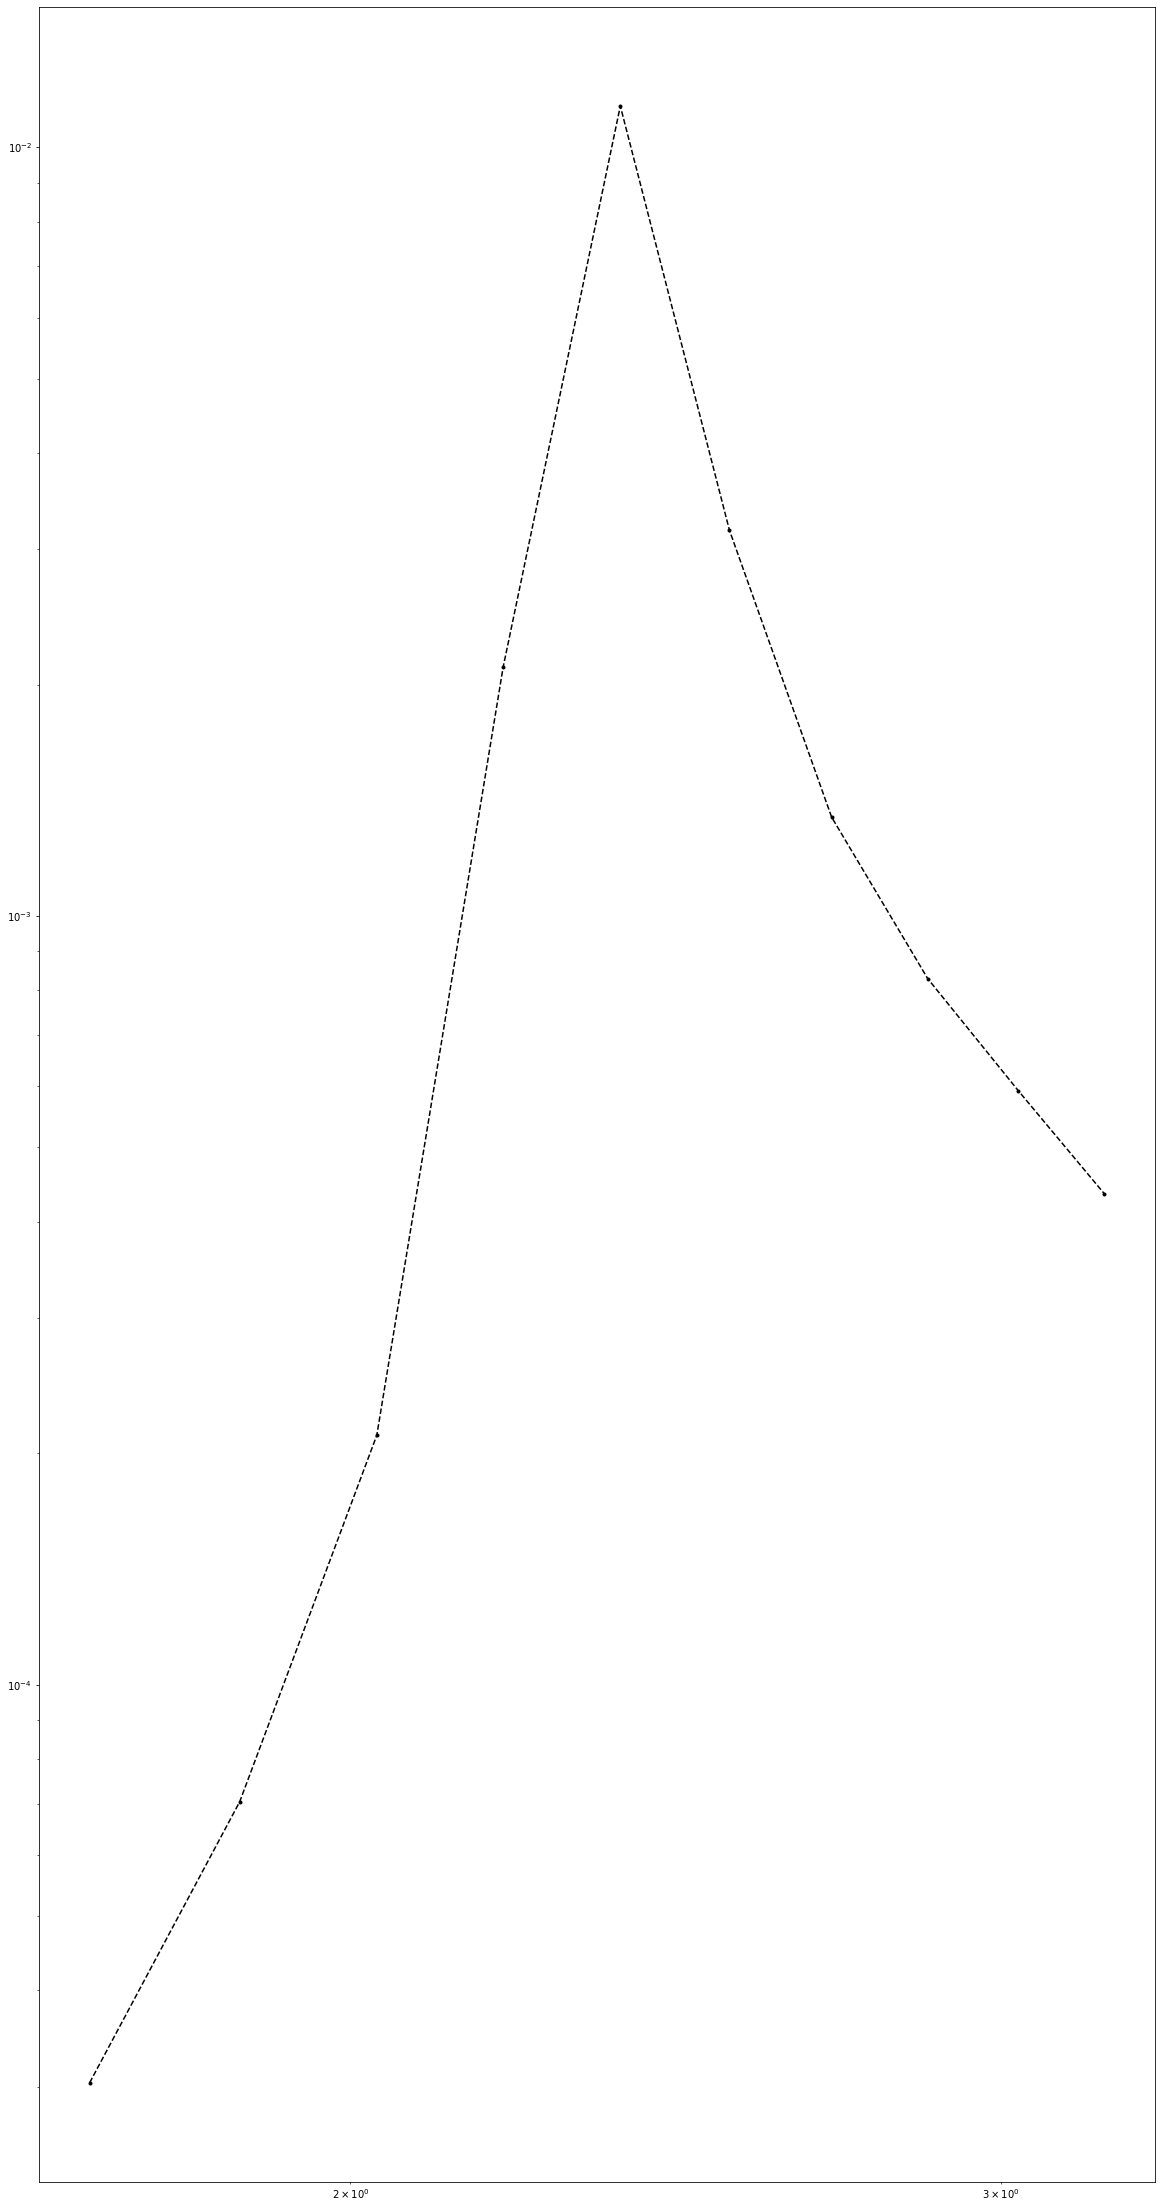

In [37]:
Temps = 10
Ts = np.linspace(1.7, 3.2, Temps)

cpus = cpu_count()
print("Detecting and using {} cpu cores.".format(cpus))
with Pool(cpus) as p:
    samples = p.map(simulate, Ts)


Es = np.empty(Temps)
Ms = np.empty(Temps)
Hc = np.empty(Temps)
Su = np.empty(Temps)
for i in range(Temps):
    s = samples[i]
    Es[i] = s["Energy"] / num_samples
    Ms[i] = s["Mag"] / num_samples
    x = (s["Energy2"] - s["Energy"]**2) / num_samples
    Hc[i] = x / Ts[i]**2
    x = (s["Mag2"] - s["Mag"]**2)
    Su[i] = x / Ts[i]

fig, ax = plt.subplots(figsize=(20, 40))
ax.loglog(Ts, Su, "k.--")
plt.show()